# Chapter 1: Introduction

This project aims to perform flood detection using Sentinel-1 satellite imagery and the Google Earth Engine platform. By comparing radar images from pre- and post-flood periods, we can identify flooded areas and visualize water extent changes over time.

- Set up the environment and initialize Google Earth Engine.
- Define the Area of Interest (AOI) and fetch satellite images.
- Process and visualize the data to detect changes in water-covered areas.


# Chapter 2: Setting Up the Environment

In this phase, we import necessary libraries and authenticate access to Google Earth Engine.

In [2]:
import ee
import geemap

# Initialize the Earth Engine API 
ee.Authenticate()
ee.Initialize(project='atu-fyp')

# Chapter 3: Choosing the area and time range

Defining the Area of Interest (AOI)


According to The Irish Times: https://www.irishtimes.com/ireland/2023/10/19/cork-flooding-floods-in-co-cork-absolutely-devastating-as-safety-warning-issued-to-motorists/

We define the AOI for Cork, Ireland, which was heavily affected by floods in 2023. This AOI will be used to fetch and analyze satellite images.

Importing Libraries & Starting Earth Engine
In this phase, we import necessary libraries and initialize Google Earth Engine to fetch and process satellite images for a specific area and time range.

In [24]:
# Define AOI for Cork
# Define pre-flood and post-flood dates
#We tell the computer when to look.
#We check images before the flood (September) and after the flood (October).

# Define coordinates using lat/lon
lat_north = 52.00904254772663
lat_south = 51.7292195887807
lon_west = -8.570156845611686
lon_east = -7.959042343658562
buffer_size = 5000  # Buffer in meters

# Create the polygon using lat/lon structure
aoi = ee.Geometry.Polygon([
    [
        [lon_west, lat_north],
        [lon_west, lat_south],
        [lon_east, lat_south],
        [lon_east, lat_north]
    ]
]).buffer(buffer_size)  # Apply buffer

# Initialize the map
Map = geemap.Map(center=[51.8691, -8.2646], zoom=10)
Map.addLayer(aoi, {'color': 'brown'}, 'Area of Interest')
Map

Map(center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Chapter 4: Data collection Loading and Visualization

## 4.1 Loading Sentinel-1 Data
This section loads and filters Sentinel-1 satellite radar data for the specified flood event timeframes.  
It prepares the data for analysis by applying filters such as date, area, and polarization.

In [25]:
# Load Sentinel-1 GRD data for pre-flood period
pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(pre_flood_start, pre_flood_end) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV')

# Load Sentinel-1 GRD data for post-flood period
post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV')

# Get the median image for each period
pre_flood_image = pre_flood_collection.median()
post_flood_image = post_flood_collection.median()

# Add pre-flood and post-flood images to the map
Map.addLayer(pre_flood_image.clip(aoi), {'min': -20, 'max': 0}, 'Pre-Flood VV')
Map.addLayer(post_flood_image.clip(aoi), {'min': -20, 'max': 0}, 'Post-Flood VV')
Map.centerObject(aoi)
Map

Map(bottom=87045.0, center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'],…

Explanation

This section loads Sentinel-1 GRD data for pre-flood and post-flood periods and visualizes the median images.

## 4.1 Water area analysis over time


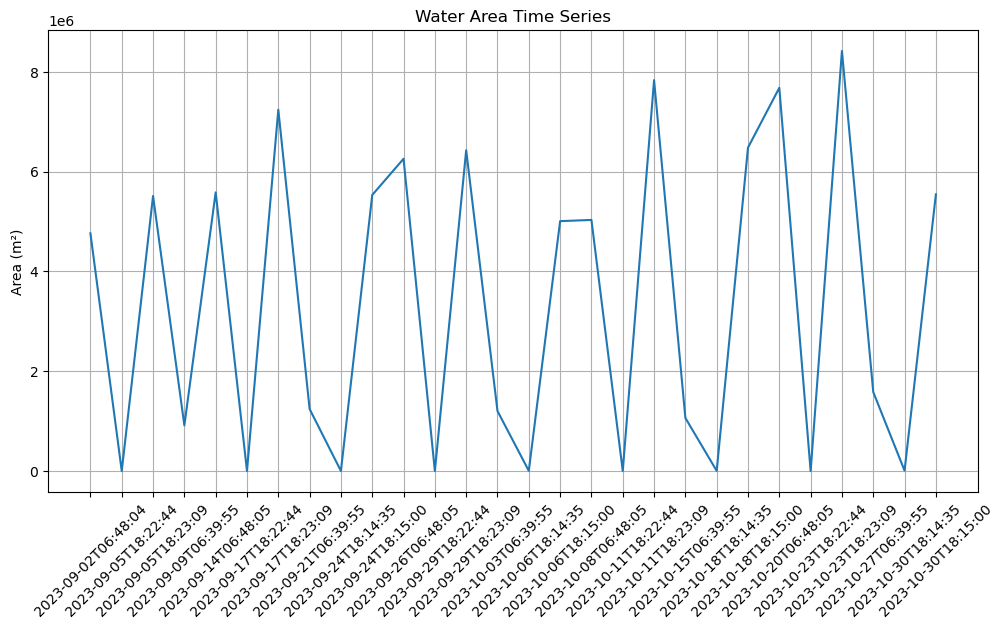

In [31]:
# Full time Collection
full_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate('2023-09-01', '2023-10-31') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Function to calculate water extent for each image
def calc_water_extent(image):
    water = image.select('VV').gt(2)  # Using your existing threshold
    area = water.multiply(ee.Image.pixelArea())
    stats = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30
    )
    return image.set({'water_area': stats.get('VV'), 'date': image.date().format()})

# Apply to collection
time_series = full_collection.map(calc_water_extent)

# Export results for plotting
timeseries_stats = time_series.aggregate_array('water_area').getInfo()
dates = time_series.aggregate_array('date').getInfo()

# Plotting 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(dates, timeseries_stats)
plt.title('Water Area Time Series')
plt.ylabel('Area (m²)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Chapter 5: Analyzing Changes
This section calculates the difference between pre-flood and post-flood images to detect changes in water-covered areas. A threshold is applied to identify flooded areas.

## 5.1 Calculate the Difference Between Pre-Flood and Post-Flood Images
We subtract the pre-flood image from the post-flood image to detect changes in water-covered areas. The difference image highlights areas where water levels have changed significantly.

## 5.2 Thresholding to Identify Flooded Areas
We apply a threshold to the difference image to create a binary flood mask. Pixels with values above the threshold are considered flooded. This mask is then visualized on the map.

This next cell calculates the difference between the post-flood and pre-flood images by subtracting the pre-flood image from the post-flood image. The resulting difference image highlights changes in the area. The difference image is then added to the map with a color palette to visualize the changes.


In [6]:
# Calculate the difference between post-flood and pre-flood images
difference_image = post_flood_image.subtract(pre_flood_image)

# Add the difference image to the map
Map.addLayer(difference_image.clip(aoi), {'min': -5, 'max': 5, 'palette': ['red', 'white', 'blue']}, 'Difference Image')
Map.centerObject(aoi)
Map


Map(bottom=87045.0, center=[51.82506488483375, -8.475000000000001], controls=(WidgetControl(options=['position…

EXPLANATION

We use colors to show the changes. Red means a lot of change, blue means less change, and white means no change.
Flood Mask: We use blue to show the places where we think there was a flood. This helps us see the flooded areas on the map.

## 5.2 Thresholding to Identify Flooded Areas
We apply a threshold to the difference image to create a binary flood mask. Pixels with values above the threshold are considered flooded. This mask is then visualized on the map.

In [7]:
# Define a threshold for flood detection
threshold = 2  # Adjust this value based on your analysis

# Create a binary flood mask
flood_mask = difference_image.gt(threshold)

# Add the flood mask to the map
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Flood Mask')
Map.centerObject(aoi)
Map

Map(bottom=173893.0, center=[51.82506488483375, -8.475000000000001], controls=(WidgetControl(options=['positio…

EXPLANATION

Thresholding: We decide how much change means there was a flood.  If the change is more than 2, there was a flood.

# Chapter 6: Exporting and Visualizing Results

Export the Flood Mask
Exporting the flood mask to Google Drive for further analysis.



In [8]:
# Export the flood mask to Google Drive
task = ee.batch.Export.image.toDrive(
    image=flood_mask.clip(aoi),
    description='FloodMask',
    folder='EarthEngineImages',
    scale=30,
    region=aoi
)
task.start()

print("Export task started. Check Google Drive for the flood mask.")

Export task started. Check Google Drive for the flood mask.


## 6.2 Visualizing Locally
Visualizing the exported flood mask locally.

Visualizing locally

In [9]:
import rasterio
from matplotlib import pyplot as plt

# Check if the file exists
import os
file_path = r"C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\FloodMask.tif"
if os.path.exists(file_path):
    # Open the exported flood mask
    with rasterio.open(file_path) as src:
        flood_mask_image = src.read(1)

    # Display the flood mask
    plt.imshow(flood_mask_image, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(label='Flood Mask')
    plt.title('Flood Mask')
    plt.show()
else:
    print(f"File not found: {file_path}")

File not found: C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\FloodMask.tif


# Chapter 7: Refining the Threshold
Experimenting with different threshold values (e.g., 1.5, 2.5) to improve flood detection accuracy
Here we test different threshold values (e.g., 1.5, 2, 2.5, 3) to refine the flood detection process. Each threshold is applied to the difference image, and the resulting flood mask is visualized on the map. This helps us determine the optimal threshold for accurate flood detection.

In [10]:
# Defining a list of threshold values to test
thresholds = [1.5, 2, 2.5, 3]

# map to visualize the results
Map = geemap.Map(center=[51.8691, -8.2646], zoom=10)

# Loops through each threshold and add the flood mask to the map
for threshold in thresholds:
    flood_mask = difference_image.gt(threshold)
    Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, f'Flood Mask (Threshold={threshold})')

# Adds the AOI and difference image for reference
Map.addLayer(aoi, {'color': 'red'}, 'Area of Interest')
Map.addLayer(difference_image.clip(aoi), {'min': -5, 'max': 5, 'palette': ['red', 'white', 'blue']}, 'Difference Image')
Map.centerObject(aoi)
Map

Map(center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

EXPLANATION

Here wer are making sure we get it right

Flood Masks for Different Thresholds: We use blue to show the places where we think there was a flood for each number we tried. This helps us see how each number works.

Visualizing the Results: We look at the map to see how well each number works. We add the flood areas to the map for each number and see which one shows the floods most accurately.





# Chapter 8: Combining Sentinel-1 and Sentinel-2 DATA
Sentinel-2 optical data used to calculate the Normalized Difference Water Index (NDWI), which is useful for validating the flood mask derived from Sentinel-1.

We load Sentinel-2 optical data for the post-flood period and calculate the NDWI, which is a useful index for detecting water bodies. The NDWI is calculated using the green (B3) and near-infrared (B8) bands. The resulting NDWI image is visualized on the map.



In [11]:

# Loading Sentinel-2 data for the post-flood period
#We ask Google Earth Engine for satellite images from Sentinel-2, a satellite that takes pictures of Earth. 
#We only take images from our area (Cork) and only in October.
#We ignore pictures that have too many clouds (less than 50% clouds allowed). 
post_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))  # Filter out cloudy images

# Function to calculate NDWI
#NDWI (Normalized Difference Water Index) is a math trick to find water in a satellite image. 
# It looks at two colors:
# B3 (Green light) 
# B8 (Near Infrared light) 
# If B3 is bright and B8 is dark, that means water! 
# We add this water-detection layer to the image.
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

# Apply NDWI calculation to the collection
ndwi_collection = post_flood_sentinel2.map(add_ndwi)

# Gets the median NDWI image
ndwi_image = ndwi_collection.median()

# Adds NDWI layer to the map
Map.addLayer(ndwi_image.clip(aoi), {'bands': ['NDWI'], 'min': -1, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI')
ndwi_vis_params = {'bands': ['NDWI'], 'min': -0.3, 'max': 0.3, 'palette': ['white', 'blue']}
Map.addLayer(ndwi_image.clip(aoi), ndwi_vis_params, 'NDWI')

Map.centerObject(aoi)
Map

Map(center=[51.82506488483375, -8.475000000000001], controls=(WidgetControl(options=['position', 'transparent_…

EXPLANATION

Sentinel-1 and Sentinel-2 We use two different satellites to get pictures. Sentinel-1 sees through clouds and Sentinel-2 sees colors.

NDWI Calculation We use Sentinel-2 to find water by looking at how much green and near-infrared light is reflected.

NDWI Water Mask We color the places where we think there is water using the NDWI calculation.

Comparing with Flood Mask We look at both the NDWI water mask and the flood mask from Sentinel-1 to see if they match.

We check if the places we found with Sentinel-1 match the places we found with Sentinel-2. This helps us make sure we are finding the floods correctly.



# Chapter 9:  VALIDATING the FLOOD MASK
Comparing the flood mask derived from Sentinel-1 with the NDWI from Sentinel-2 to validate the results.

We compare the flood mask derived from Sentinel-1 with the NDWI water mask from Sentinel-2. This helps us validate the accuracy of the flood detection. Areas where both masks overlap are likely true flooded areas, while discrepancies may indicate false positives or false negatives.

In [ ]:
# Defines a threshold for NDWI (values > 0.3 indicate water)
# What this does:
# We set a "rule" : Any place with an NDWI value higher than 0.3 is water.
ndwi_threshold = 0.3
ndwi = ndwi_image.select('NDWI').gt(ndwi_threshold)

# Adds the NDWI water mask to the map
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')

# Compares with the Sentinel-1 flood mask
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Sentinel-1 Flood Mask')
Map.centerObject(aoi)
Map

Map(center=[51.86932901232889, -8.264599594635124], controls=(WidgetControl(options=['position', 'transparent_…


KeyboardInterrupt



EXPLANATION

This code creates a mask (a special filter) to highlight only the water areas on the map. It looks at the NDWI values and decides which pixels are water and which are not water.


Sentinel-1 is another satellite (different from Sentinel-2).



Validation We want to make sure that the places we found as flooded are really flooded.
NDWI Water Mask: We use the NDWI (Normalized Difference Water Index) from Sentinel-2 to identify water areas and compare it with the flood mask from Sentinel-1.

Comparing with the Sentinel-1 Flood Mask:

Explanation: We add the flood mask from Sentinel-1 to the map, using green to show the areas identified as flooded. This allows us to visually compare the two masks.

EXPORTING RESULTS


In [ ]:
# Export NDWI water mask
task_ndwi = ee.batch.Export.image.toDrive(
    image=ndwi.clip(aoi),
    description='NDWI_WaterMask',
    folder='EarthEngineImages',
    scale=10,
    region=aoi
)
task_ndwi.start()

# Export NDWI water mask
task_ndwi = ee.batch.Export.image.toDrive(
    image=ndwi.clip(aoi),
    description='NDWI_WaterMask',
    folder='EarthEngineImages',
    scale=10,
    region=aoi
)
task_ndwi.start()
print("Export tasks started. Check Google Drive for the validation results.")

Export tasks started. Check Google Drive for the validation results.


In [ ]:
import rasterio
from matplotlib import pyplot as plt
import os

# Check if the Sentinel-1 flood mask file exists
flood_mask_path = r"C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\Sentinel1_FloodMask.tif"
if os.path.exists(flood_mask_path):
    # Open the exported Sentinel-1 flood mask
    with rasterio.open(flood_mask_path) as src:
        flood_mask_image = src.read(1)

    # Display the Sentinel-1 flood mask
    plt.subplot(1, 2, 2)
    plt.imshow(flood_mask_image, cmap='Greens', vmin=0, vmax=1)
    plt.colorbar(label='Sentinel-1 Flood Mask')
    plt.title('Sentinel-1 Flood Mask')

    plt.show()
else:
    print(f"File not found: {flood_mask_path}")

File not found: C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\Sentinel1_FloodMask.tif


# CHAPTER 10: Anazyling results

In [ ]:
# Load Sentinel-2 imagery for the post-flood period
post_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter out cloudy images

# Get the first Sentinel-2 image for visualization
sentinel2_image = post_flood_sentinel2.first()

# Add Sentinel-2 true color image to the map
Map.addLayer(sentinel2_image.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 True Color')

# Add the flood mask and NDWI water mask for comparison
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Sentinel-1 Flood Mask')
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')

# Add the AOI for reference
Map.addLayer(aoi, {'color': 'red'}, 'Area of Interest')
Map.centerObject(aoi)
Map

Map(center=[51.86932901232889, -8.264599594635124], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:

# For demonstration, we'll use the NDWI water mask as validation data
reference_data = ndwi

# Calculate confusion matrix
confusion_matrix = flood_mask.add(reference_data.multiply(2)).clip(aoi)

# Add confusion matrix to the map
Map.addLayer(confusion_matrix, {'min': 0, 'max': 3, 'palette': ['white', 'green', 'blue', 'red']}, 'Confusion Matrix')
Map.centerObject(aoi)
Map

Map(center=[51.86932901232889, -8.264599594635124], controls=(WidgetControl(options=['position', 'transparent_…

EXPLANATION

The NDWI water mask (blue) represents water bodies detected by Sentinel-2.

The Sentinel-1 flood mask (green) represents flooded areas detected by Sentinel-1.

Overlaying the two masks to see how well they align.

Here we look for areas where both masks (blue and green) overlap. These are likely true flooded areas.

Areas where only one mask detects water may indicate false positives or false negatives.

Quantitive Validation

In [ ]:
# Defines a threshold for NDWI (values > 0.3 indicate water)
ndwi_threshold = 0.3
ndwi = ndwi_image.select('NDWI').gt(ndwi_threshold)

# Adds the NDWI water mask to the map
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')

# For demonstration, we'll use the NDWI water mask as ground truth
reference_data = ndwi

# Combine flood mask and NDWI water mask to generate a confusion matrix
# Values:
# 0 = Neither predicted nor actual (True Negative)
# 1 = Predicted flood, not actual (False Positive)
# 2 = Actual flood, not predicted (False Negative)
# 3 = Correctly predicted flood (True Positive)
confusion_matrix = flood_mask.add(reference_data.multiply(2)).clip(aoi)


# Adds confusion matrix to the map
Map.addLayer(confusion_matrix, {'min': 0, 'max': 3, 'palette': ['white', 'green', 'blue', 'red']}, 'Confusion Matrix')
Map.centerObject(aoi)
Map

# Calculates true positives, false positives, and false negatives
true_positives = confusion_matrix.eq(3).rename('TP')
false_positives = confusion_matrix.eq(1).rename('FP')
false_negatives = confusion_matrix.eq(2).rename('FN')

# Sums the values over the AOI
tp_sum = true_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TP').getInfo()
fp_sum = false_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FP').getInfo()
fn_sum = false_negatives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FN').getInfo()

# Calculates metrics
accuracy = (tp_sum) / (tp_sum + fp_sum + fn_sum)
precision = tp_sum / (tp_sum + fp_sum)
recall = tp_sum / (tp_sum + fn_sum)

# Prints the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Visualize flood mask and verified data
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'red']}, 'Flood Mask')
Map.addLayer(reference_data.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Ground Truth')
Map

Accuracy: 0.00
Precision: 0.00
Recall: 0.00


Map(bottom=87044.0, center=[51.86970795368951, -8.265151977539064], controls=(WidgetControl(options=['position…

EXPLANATION 

True Positives (TP): Areas where both Sentinel-1 and NDWI detect water.

False Positives (FP): Areas where Sentinel-1 detects water, but NDWI does not.

False Negatives (FN): Areas where NDWI detects water, but Sentinel-1 does not.

Accuracy: Percentage of correctly identified flooded areas.

Precision: Percentage of detected floods that are correct.

Recall: Percentage of actual floods that were detected.